<a href="https://colab.research.google.com/github/GurjeetSinghSangra/MachineLearningAssignment/blob/main/emnist_DBN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-plot
#%matplotlib tk
##################################################
# Imports
##################################################
import numpy as np
import numpy.matlib
import math
import scipy.io
from sklearn import svm, datasets
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn #torch made by layers, in nn we have linear layer which implements standard forward fully connected layer
import torch.nn.functional as F 
import torchvision #used for data loading
import torch.optim as optim #optimizer for the gradient
from tqdm.notebook import tqdm
import time
import scikitplot as skplt
import matplotlib.gridspec as gridspec
from skimage.util import random_noise


# Setting the device
if torch.cuda.is_available(): 
    print('GPU enabled!')
    device = torch.device("cuda:0")
else:
    print('You are not using the GPU, activate it following:')
 

GPU enabled!


## DBN Model

In [30]:
class DBN(nn.Module):

  def __init__(self, layers_nn, maxepochs=50, batchsize=150, epsilonw=0.1, \
                               sparsity=True, spars_factor=0.04, epsilonvb=0.1, epsilonhb=0.1, weightcost=0.0002, init_momentum=0.5, final_momentum=0.9):
    super(DBN, self).__init__()
    self.DN = {}
    self.DN['layersize'] = layers_nn
    self.DN['nlayers'] = len(layers_nn)
    self.DN['batchsize'] = batchsize
    self.DN['maxepochs'] = maxepochs
    self.epsilonw_GPU = epsilonw #learning rate DeltaW = epsilonw (pos_v * pos_h - neg_v * neg_h)
    self.epsilonvb=epsilonvb
    self.epsilonhb=epsilonhb
    self.weightcost = weightcost #constant weight decrease
    self.initialmomentum = init_momentum
    self.finalmomentum = final_momentum
    self.sparsity = sparsity
    self.spars_factor = spars_factor
    self.DN['errors'] = {}
  
  def train_dbn(self, batch, device):

    batchdata = torch.Tensor(batch).to(device)
    nlayers = self.DN['nlayers']
    for layer in range(0, nlayers):
        print ('Training layer ', layer+1, '...')
        if layer == 0:
            data_GPU = batchdata
        else:
            data_GPU = batchposhidprobs
        
        numhid = self.DN['layersize'][layer]
        numcases, numdims, numbatches = data_GPU.shape
        vishid_GPU       = 0.1 * torch.randn(numdims, numhid, device=device) #normal dist weights with standard deviation 0.01
        #print(vishid_GPU.shape)
        hidbiases_GPU    = torch.zeros(numhid, device=device)
        visbiases_GPU    = torch.zeros(numdims, device=device)
        vishidinc_GPU    = torch.zeros((numdims, numhid), device=device)
        hidbiasinc_GPU   = torch.zeros(numhid, device=device)
        visbiasinc_GPU   = torch.zeros(numdims, device=device)
        batchposhidprobs = torch.zeros((numcases, numhid, numbatches), device=device)
        self.DN['errors'][layer] = []


        sigmoid = nn.Sigmoid()
        for epoch in range(self.DN['maxepochs']):
            errsum = 0
            for mb in range(numbatches):
                data_mb = data_GPU[:, :, mb]
                #%%%%%%%% START POSITIVE PHASE %%%%%%%%%
                #1./(1 + exp(-poshidstates * vishid' - repmat(visbiases, numcases, 1))); 
                poshidprobs_GPU = sigmoid((torch.mm(data_mb, vishid_GPU) + hidbiases_GPU))
                posprods_GPU    = torch.mm(data_mb.T, poshidprobs_GPU)
                poshidact_GPU   = poshidprobs_GPU.sum(0)
                #posvisact_GPU   = data_GPU[:, :, mb].sum(0)
                posvisact_GPU   = data_mb.sum(0)
                #%%%%%%%% END OF POSITIVE PHASE %%%%%%%%%
                poshidstates_GPU = poshidprobs_GPU > (torch.rand(numcases, numhid, device=device))
                poshidstates_GPU = torch.gt(poshidstates_GPU, 0).float()

                #%%%%%%%% START NEGATIVE PHASE  %%%%%%%%%
                negdata_GPU     = sigmoid((torch.mm(poshidstates_GPU, vishid_GPU.T) + visbiases_GPU))
                neghidprobs_GPU = sigmoid((torch.mm(negdata_GPU, vishid_GPU) + hidbiases_GPU))
                negprods_GPU    = torch.mm(negdata_GPU.T, neghidprobs_GPU)
                neghidact_GPU   = neghidprobs_GPU.sum(0)
                negvisact_GPU   = negdata_GPU.sum(0)
                #%%%%%%%% END OF NEGATIVE PHASE %%%%%%%%%
                
                err = torch.sqrt(torch.sum(torch.sum((data_mb - negdata_GPU)**2, dim=0)))
                if self.DN['maxepochs']  > 5:
                  self.momentum = self.finalmomentum
                else:
                  self.momentum = self.initialmomentum

                #%%%%%%%% UPDATE WEIGHTS AND BIASES %%%%%%%%%
                vishidinc_GPU  = vishidinc_GPU  * self.momentum + self.epsilonw_GPU * ((posprods_GPU - negprods_GPU) / numcases - self.weightcost * vishid_GPU)
                visbiasinc_GPU = visbiasinc_GPU * self.momentum + (posvisact_GPU - negvisact_GPU) * (self.epsilonvb / numcases)
                hidbiasinc_GPU = hidbiasinc_GPU * self.momentum + (poshidact_GPU - neghidact_GPU) * (self.epsilonhb / numcases)
                vishid_GPU     = vishid_GPU + vishidinc_GPU
                visbiases_GPU  = visbiases_GPU + visbiasinc_GPU
                hidbiases_GPU  = hidbiases_GPU + hidbiasinc_GPU
                #%%%%%%%% END OF UPDATES %%%%%%%%%
                # END RBM
                
                errsum = err + errsum

                if epoch == self.DN['maxepochs']-1:
                    batchposhidprobs[:, :, mb] = poshidprobs_GPU

                #TODO: Sparsity
                if self.sparsity and (layer == nlayers-1):
                  #poshidact_GPU = poshidprobs_GPU.sum(0)
                  Q = poshidact_GPU / self.DN['batchsize']
                  if (torch.mean(Q) > self.spars_factor):
                    hidbiases_GPU = hidbiases_GPU - self.epsilonhb * (Q - self.spars_factor)
              
            #END Batches
            self.DN['errors'][layer].append((epoch, errsum.detach().cpu().numpy()))
          #END Epoches

        # save learned weights
        self.DN['vis_bias' + str(layer)] = visbiases_GPU.detach().cpu().numpy()
        self.DN['hid_bias' + str(layer)] = hidbiases_GPU.detach().cpu().numpy()
        self.DN['vishid'   + str(layer)] = vishid_GPU.detach().cpu().numpy()
        
        #print(self.DN['vishid'   + str(layer)].shape)

  def simple_load_emnist(fname): 
    dataset = scipy.io.loadmat(fname)
    data_train = dataset['dataset']['train']
    data_test = dataset['dataset']['test']
    x_train = data_train[0,0]['images'][0,0]
    x_train = x_train.astype('float32') / 255
    y_train = data_train[0,0]['labels'][0,0]
    y_train = y_train.astype(int)
    x_test = data_test[0,0]['images'][0,0]
    x_test = x_test.astype('float32')  / 255
    y_test = data_test[0,0]['labels'][0,0]
    y_test = y_test.astype(int)
    return (x_train, y_train, x_test, y_test)

  def load_data(fname, NUMB_CLASSES, batchsize):
    dataset = scipy.io.loadmat(fname)
    data_train = dataset['dataset']['train']
    data_test = dataset['dataset']['test']
    x_train = data_train[0,0]['images'][0,0]
    x_train = x_train.astype('float32') / 255
    y_train = data_train[0,0]['labels'][0,0]
    y_train = y_train.astype(int)
    x_test = data_test[0,0]['images'][0,0]
    x_test = x_test.astype('float32')  / 255
    y_test = data_test[0,0]['labels'][0,0]
    y_test = y_test.astype(int)

    iterations = int(len(x_train)/batchsize)
    batchdata = np.zeros(shape=(batchsize, 784, iterations), dtype='float32')

    for i in range(batchsize):
      for j in range(iterations):
        batchdata[i, :,j] = x_train[i*j, :]

    length_train = int(len(x_train))
    tr_labels = np.zeros(shape=(length_train, NUMB_CLASSES))
    for i in range(length_train):
        tr_labels[i, y_train[i]] = 1.0

    length_test = int(len(y_test))
    te_labels = np.zeros(shape=(length_test, NUMB_CLASSES))
    for i in range(length_test):
        te_labels[i, y_test[i]] = 1.0

    return (x_train, tr_labels, x_test, te_labels, batchdata)


  def to_string(self):
      if self.sparsity:
        sparsity_text = ' Sparse'
      else:
        sparsity_text = ''
      return "DBN: {0} {1} {2} {3}".format(str(self.DN['layersize']), \
                                             self.DN['batchsize'], \
                                             self.DN['maxepochs'], sparsity_text)
      
  def get_learned_map_features (self, input, layer_idx):
    vishid = self.DN['vishid' + str(layer_idx)]
    hid_bias = self.DN['hid_bias' + str(layer_idx)]
    H_feature = 1 /(1 + np.exp(-np.dot(input, vishid) - np.matlib.repmat(hid_bias, len(input), 1)));
    return H_feature
  

## Utils Functions

In [2]:
def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
def save_to_matlab_model(dbn_model):
  savematname = 'DN_COLAB_{0}.mat'.format(dbn_model.to_string())
  scipy.io.savemat(savematname, {'DN': dbn_model.DN})

np.set_printoptions(precision=2)        
#images = np.apply_along_axis(rotate, 1, x_train)
#plt.imshow(images[1,], cmap=plt.get_cmap('gray')) 

In [4]:
class HyperParameterConf:
####### HYPER PARAMTERS of DBN ####################
# layers_nn, maxepochs=50, batchsize=125, epsilonw=0.1,
# sparsity=True, spars_factor=0.04, epsilonvb=0.1, epsilonhb=0.1, 
# weightcost=0.0002, init_momentum=0.5, final_momentum=0.9):

  def __init__(self, layers_nn, maxepochs=50, batchsize=125, epsilonw=0.1, \
               sparsity=True, spars_factor=0.04, epsilonvb=0.1, epsilonhb=0.1, \
               weightcost=0.0002, init_momentum=0.5, final_momentum=0.9):
    
    self.layers = layers_nn
    self.batchsize= batchsize
    self.maxepochs = maxepochs
    self.epsilonw = epsilonw #learning rate DeltaW = epsilonw (pos_v * pos_h - neg_v * neg_h)
    self.epsilonvb=epsilonvb
    self.epsilonhb=epsilonhb
    self.weightcost = weightcost #constant weight decrease
    self.init_momentum = init_momentum
    self.final_momentum = final_momentum
    self.sparsity = sparsity
    self.spars_factor = spars_factor
  
  def get_dbn_model(self):
    return DBN(layers_nn=self.layers, maxepochs=self.maxepochs, \
               batchsize=self.batchsize, epsilonw=self.epsilonw, \
               sparsity=self.sparsity, spars_factor=self.spars_factor, \
               epsilonvb=self.epsilonvb, epsilonhb=self.epsilonhb, \
               weightcost=self.weightcost, init_momentum=self.init_momentum, \
               final_momentum=self.final_momentum)
    
  def to_string(self):
      if self.sparsity:
        sparsity_text = ' Sparse'
      else:
        sparsity_text = ''
      return "DBN: {0}, {1}, {2} {3}".format(str(self.layers), \
                                             self.batchsize, \
                                             self.maxepochs, sparsity_text)
  

In [5]:
def plot_accuracies (dbn_title, dbn_idx, results, axis):
  width=0.35
  tr_accuracies = [results[0][0]['tr_accuracy']]
  te_accuracies = [results[0][0]['te_accuracy']]
  #concatate first results with others
  
  tr_accuracies = tr_accuracies + list(map(lambda val: val['tr_accuracy'], results[dbn_idx]))
  te_accuracies = te_accuracies + list(map(lambda val: val['te_accuracy'], results[dbn_idx]))
  tr_accuracies = np.array(tr_accuracies) * 100
  te_accuracies = np.array(te_accuracies) * 100

  x = np.arange(len(results[dbn_idx])+1) 
  print(tr_accuracies)
  print(tr_accuracies)
  print(x - width/2)
  bar_tr = axis.bar(x - width/2, tr_accuracies, width, label='Train. Acc.')
  bar_te = axis.bar(x + width/2, te_accuracies, width, label='Test Acc.')
  axis.set_xticks(x)
  x_labels = list(map(lambda value : 'Layer {0}'.format(value), x))
  x_labels[0] = 'Pixels'
  axis.set_xticklabels(x_labels)
  axis.legend(loc='upper left')
  axis.set_label("Percentage")
  axis.set_title("Read-outs Acc. {0}".format(dbn_title))
  minimum = min(tr_accuracies.min(), te_accuracies.min())
  if minimum > 5:
    minimum -= 4
  axis.set_ylim(minimum, 100)
  autolabel(bar_tr, axis)
  autolabel(bar_te, axis)

In [6]:
ascii_fun = np.vectorize(lambda x: chr(x))

def balanced_map_labels(label):
  if label < 10:
    return label + 48
  elif label < 36:
    return label + 54
  elif label <38:
    return label + 61
  elif label < 43:
    return label + 62
  elif label == 43:
    return label + 67
  elif label < 46:
    return label + 69
  else:
    return 116 #46

letters_map_fun = np.vectorize(lambda x: x+64)
balanced_map_fun = np.vectorize(balanced_map_labels)

def plot_errors(dbn_model, axis, idx_model):
  nlayers = dbn_model.DN['nlayers']
  legends = []
  legend_name = []
  for layer in range(nlayers):
    values = dbn_model.DN['errors'][layer]
    x, y = zip(*values)
    leg,  = axis.plot(x, y)
    legends.append(leg)
    legend_name.append('L{0}'.format(layer+1))

  axis.legend(legends, legend_name, loc='upper right', shadow=True)
  title = 'Errors DBN model {0}'.format(idx_model)
  axis.set_title(title)

def plot_conf_matrix(y_test, pred, title, axes, namedataset):
  y_label_dec = np.argmax(y_test, axis=1)  
  y_label_pred = np.argmax(pred, axis=1)
  if namedataset == 'letters':
    y_label_dec = letters_map_fun(y_label_dec)
    y_label_pred = letters_map_fun(y_label_pred)
  else:
    y_label_dec = balanced_map_fun(y_label_dec)
    y_label_pred = balanced_map_fun(y_label_pred)
  y_label_dec = ascii_fun(y_label_dec)
  y_label_pred = ascii_fun(y_label_pred)
  skplt.metrics.plot_confusion_matrix(
      y_label_dec, 
      y_label_pred, normalize=True, title=title, ax = axes)

In [7]:
def plot_visihidlayers(DN, idx_layers, n_hidden, figsize):

  v, h = DN['vishid0'].shape # number of visible and hidden units
  imgsize = int(math.sqrt(v));
  if n_hidden > h:
      n_hidden = h;

  n_x = math.floor(math.sqrt(n_hidden))
  n_y = n_x
  n_hidden = n_x * n_y;

  
  for layer in idx_layers:
    row = 0
    column = 0
    fig, axes = plt.subplots(n_x, n_x, figsize=figsize)
    fig.suptitle("Visible Hidd. Layer {0}".format(layer+1), fontsize=14)

    ## Visible hidden neuron sum weights calculation
    for i_n in range(n_hidden):
      prev_weights = None
      for id_layer in range(layer+1) :
        vishidname = 'vishid{0}'.format(id_layer)
        if id_layer == layer:
          weights = DN[vishidname][:, i_n]
        else:
          weights = DN[vishidname]
        weights = np.multiply(weights, (np.abs(weights) > 0.0))
        if prev_weights is not None:
          weights = prev_weights.dot(weights)
          weights = np.multiply(weights, np.abs(weights) > 0.0)
        prev_weights = weights

      if column == n_y:
        row += 1
        column = 0
      axis = axes[row, column]
      
      axis.imshow(weights.reshape((imgsize, imgsize)), cmap=plt.cm.gray)
      column +=1

    plt.show()


In [8]:
from scipy.linalg import lstsq

def predict(model_weight, x, labels, addbias=True):
  if addbias:
    x_m =  np.hstack((x, np.ones((len(x), 1))))
  else:
    x_m = x
  pred = np.dot(x_m, model_weight)
  max_act_idx = np.argmax(pred, axis=1)
  r = np.nonzero(labels)[1]
  acc = (max_act_idx == r)
  return (np.mean(acc), pred)

def perceptron_CPU(tr_patterns, tr_labels, te_patterns, te_labels):

  te_accuracy = 0;
  tr_accuracy = 0;

  # add biases and train perceptron
  tr_patterns_CPU = np.hstack((tr_patterns, np.ones((len(tr_patterns), 1))))
  weights, res, rnk, s= lstsq(tr_patterns_CPU, tr_labels) 
  # training accuracy
  tr_accuracy, pred = predict(weights, tr_patterns_CPU, tr_labels, addbias=False)

  # test accuracy
  te_accuracy, pred = predict(weights, te_patterns, te_labels)
  accur = {"tr_accuracy": tr_accuracy, "te_accuracy": te_accuracy}
  return (accur, pred, weights)

def train_predict(dbn_model, input_train, output_train, input_test, output_test, layer_idx):
  vishid = dbn_model.DN['vishid' + str(layer_idx)]
  hid_bias = dbn_model.DN['hid_bias' + str(layer_idx)]
  H_tr = 1 /(1 + np.exp(-np.dot(input_train, vishid) - np.matlib.repmat(hid_bias, len(input_train), 1)));
  H_te = 1 /(1 + np.exp(-np.dot(input_test, vishid) - np.matlib.repmat(hid_bias, len(input_test), 1)));
  accuracy, pred, weights = perceptron_CPU(H_tr, output_train, H_te, output_test)
  return (accuracy, pred, weights)

## Training and Test

### Run configuration 

In [38]:
namedataset = 'letters'
fname = ('/home/emnist-' + namedataset + '.mat')

batch_dict = {"mnist" : 125,
              "letters" : 240,
              "digits" : 200,
              "balanced" :  200}
NUMB_CLASSES = {"mnist" : int(10),
              "letters" : int(37),
              "digits" : int(10),
              "balanced" :  int(47)}

####### HYPER PARAMTERS of DBN ####################
# layers_nn, maxepochs=50, batchsize=125, epsilonw=0.1,
# sparsity=True, spars_factor=0.04, epsilonvb=0.1, epsilonhb=0.1, 
# weightcost=0.0002, init_momentum=0.5, final_momentum=0.9):

# Models to run
dbn_models_conf = []

dbn_models_conf.append(HyperParameterConf(layers_nn = np.array([784, 500, 500, 2000]), \
                           epsilonw=0.1, batchsize=batch_dict[namedataset], \
                           maxepochs=100, sparsity=False))
#dbn_models_conf.append(HyperParameterConf(layers_nn = np.array([784, 500, 500, 2000]), \
#                           epsilonw=0.3, batchsize=batch_dict[namedataset], \
#                           maxepochs=100, sparsity=True, spars_factor=0.06))


In [35]:
namedataset = 'mnist'
fname = ('/home/emnist-' + namedataset + '.mat')
batch_dict = {"mnist" : 125,
              "letters" : 240,
              "digits" : 200,
              "balanced" :  200}
NUMB_CLASSES = {"mnist" : int(10),
              "letters" : int(37),
              "digits" : int(10),
              "balanced" :  int(47)}

# Models to run
dbn_models_conf = []
dbn_models_conf.append(HyperParameterConf(layers_nn = np.array([200, 500]), \
                           epsilonw=0.1, batchsize=batch_dict[namedataset], \
                           maxepochs=20, sparsity=True))
dbn_models_conf.append(HyperParameterConf(layers_nn = np.array([100, 200]), \
                           epsilonw=0.1, batchsize=batch_dict[namedataset], \
                           maxepochs=20, sparsity=True))

### Run

Raw Data perceptron Accuracy: 59.30, test accuracy: 57.79
DBN model 1 DBN: [ 784  500  500 2000] 240 100 
Training begin
Training layer  1 ...
Training layer  2 ...
Training layer  3 ...
Training layer  4 ...
Time diff 184
Training done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


Read out Level 1 DBN layer accuracy: 81.99, test accuracy: 81.59
Read out Level 2 DBN layer accuracy: 78.77, test accuracy: 78.32
Read out Level 3 DBN layer accuracy: 80.05, test accuracy: 79.73
Read out Level 4 DBN layer accuracy: 88.12, test accuracy: 87.48
[59.3  81.99 78.77 80.05 88.12]
[59.3  81.99 78.77 80.05 88.12]
[-0.17  0.82  1.82  2.83  3.83]


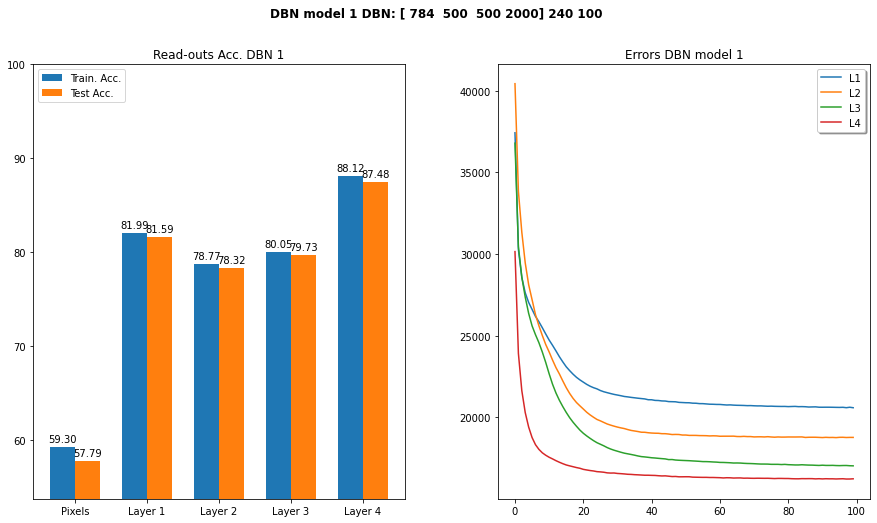

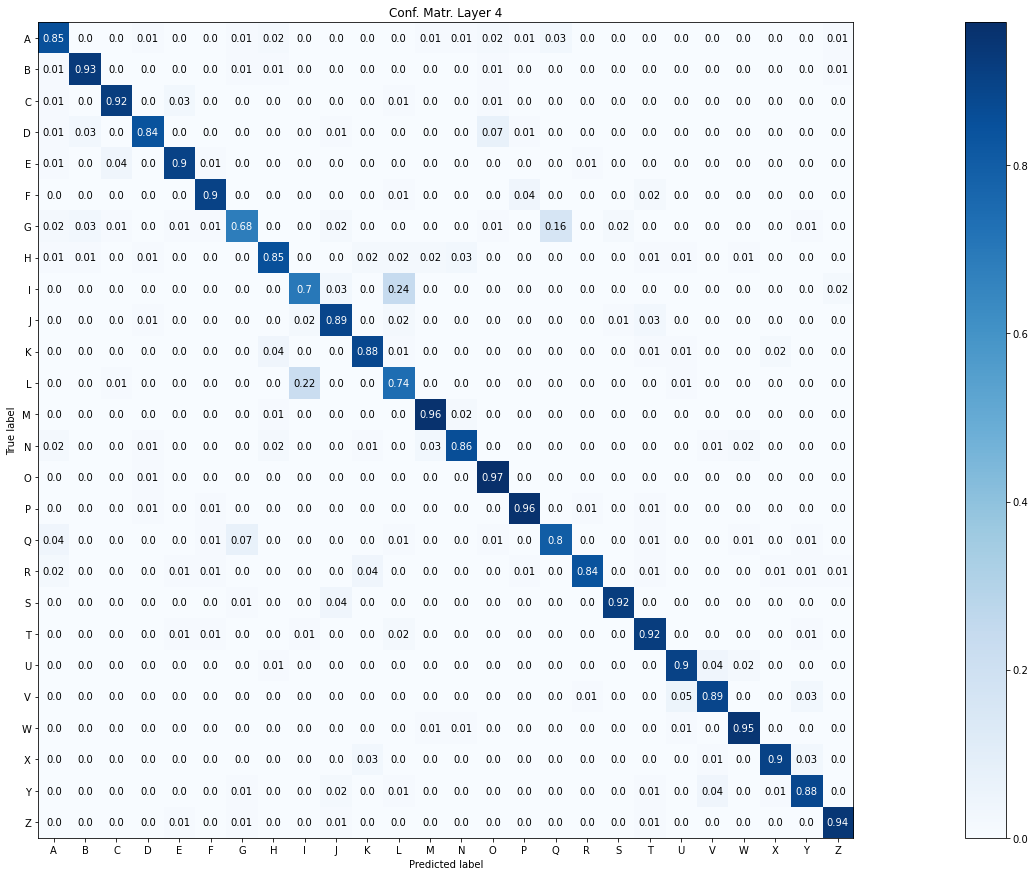

In [39]:
print_layer_matr = False
results = {}
x_train, y_train, x_test, y_test, batch_data = DBN.load_data(fname, NUMB_CLASSES[namedataset], batch_dict[namedataset])
del batch_data
accuracy, _, raw_model_weights = perceptron_CPU(x_train, y_train, x_test, y_test)
results[0] = [accuracy.copy()]
print('Raw Data perceptron Accuracy: {0:.2f}, test accuracy: {1:.2f}'.format( \
                accuracy['tr_accuracy'] * 100, accuracy['te_accuracy'] * 100))
del accuracy

n_models = len(dbn_models_conf)

i = 1

res_idx = i
prev_nlayers = 0
width=0.35
layer_model_weights = {}

for dbn_model_conf in dbn_models_conf:
  results[i] = []
  dbn_model = dbn_model_conf.get_dbn_model()
  x_train, y_train, x_test, y_test, batch_data = DBN.load_data(fname, NUMB_CLASSES[namedataset], dbn_model.DN['batchsize'])
  DBN_model_name = "DBN model {0} {1}".format(i, dbn_model.to_string())
  print(DBN_model_name)
  print('Training begin')
  x1 = time.strftime('%s')
  dbn_model.train_dbn(batch_data, device=device)
  x2 = time.strftime('%s')
  print('Time diff {0}'.format(int(x2) - int(x1)))
  print("Training done")
  
  save_to_matlab_model(dbn_model=dbn_model)
  
  nlayers = dbn_model.DN['nlayers']
  #Prepare subplots
  fig = plt.figure(i, figsize=(15, 8),constrained_layout=True)
  fig.suptitle(DBN_model_name, fontsize=12, fontweight='bold')
  fig.subplots_adjust(hspace=.25, wspace=.25)
  N_ROWS_PLOT = nlayers + 1
  N_COLUMN_PLOT = 2
  
  if not print_layer_matr:
    gs = fig.add_gridspec(nrows=1, ncols=2)
  else:
    gs = fig.add_gridspec(nrows=N_ROWS_PLOT, ncols=2)

  pred = None
  prev_train = x_train.copy()
  prev_test = x_test.copy()
  for layer_idx in range(nlayers):
    H_tr = dbn_model.get_learned_map_features(prev_train, layer_idx)
    H_te = dbn_model.get_learned_map_features(prev_test, layer_idx)
    accuracy, pred, layer_model_weights[layer_idx] = perceptron_CPU(H_tr, y_train, H_te, y_test)
    results[i].append(accuracy)
    tr_accuracy  = accuracy['tr_accuracy']
    te_accuracy = accuracy['te_accuracy'] 
    print('Read out Level {0} DBN layer accuracy: {1:.2f}, test accuracy: {2:.2f}'.format(layer_idx+1, tr_accuracy  * 100, te_accuracy  * 100))

    #PLOT Confusion Matrix
    if print_layer_matr:
      row = layer_idx + 1
      axis = fig.add_subplot(gs[row, :])
      #axis = plt.subplot2grid((N_ROWS_PLOT , N_COLUMN_PLOT), (row, 0), rowspan=4, fig=fig)
      plot_conf_matrix(y_test, pred, 'Conf. Matr. Layer {0}'.format(layer_idx+1), axis, namedataset=namedataset)
    ##
    prev_train = H_tr
    prev_test = H_te
  
  
  #axis = plt.subplot2grid((N_ROWS_PLOT , N_COLUMN_PLOT), (0,0), fig=fig)
  #PLOT Accuracies
  axis = fig.add_subplot(gs[0, 0])
  plot_accuracies('DBN {0}'.format(i), i, results, axis)
  #### PLOT Errors
  #axis = plt.subplot2grid((N_ROWS_PLOT , N_COLUMN_PLOT), (0,1), fig=fig)
  axis = fig.add_subplot(gs[0, 1])
  plot_errors(dbn_model, axis, i)
  plt.show()
  #PLOT Confusion Matrix
  if not print_layer_matr:
    fig, ax = plt.subplots(figsize=(40,15))
    plot_conf_matrix(y_test, pred, 'Conf. Matr. Layer {0}'.format(layer_idx+1), ax, namedataset)
    plt.show()
  ##
  prev_nlayers = nlayers
  i = i +1
  res_idx += 1


## Noise analysis

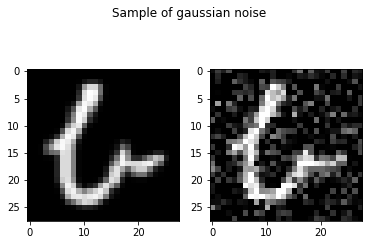

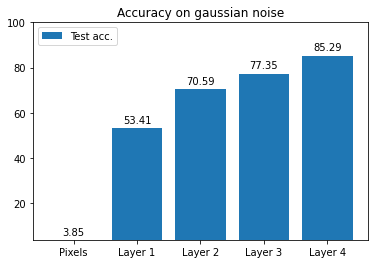

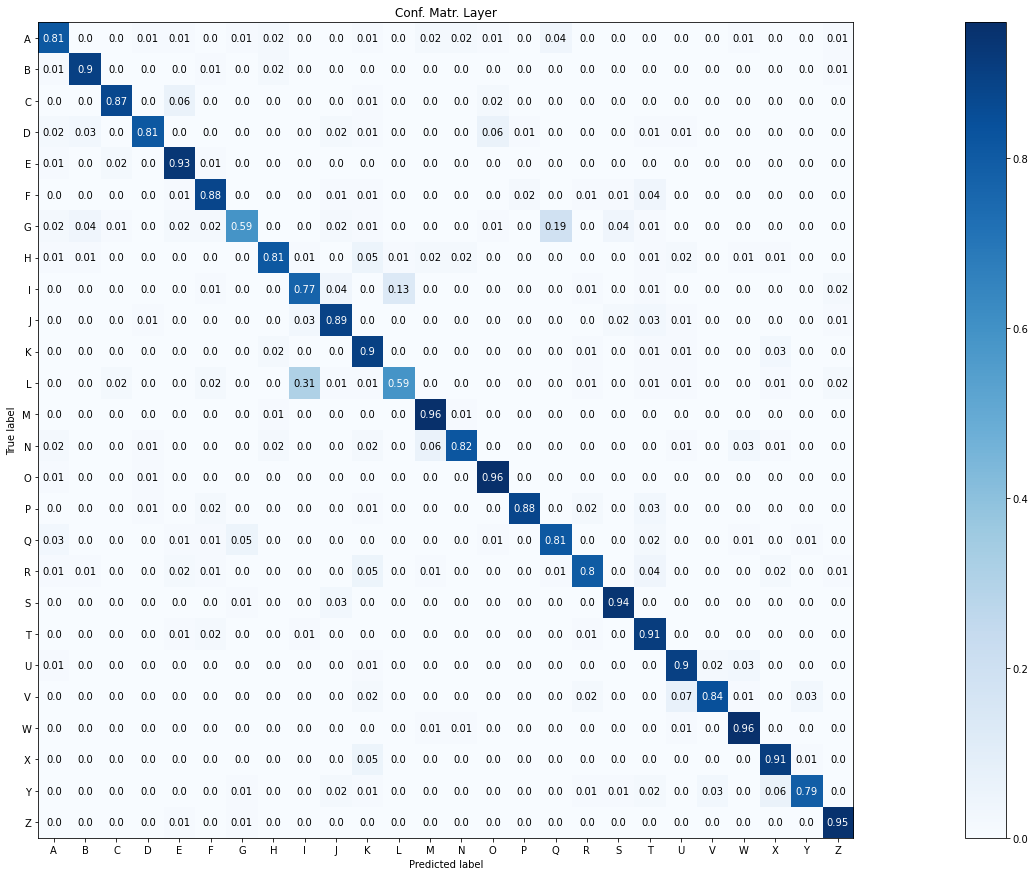

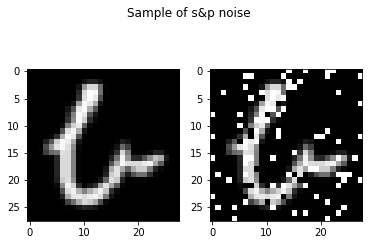

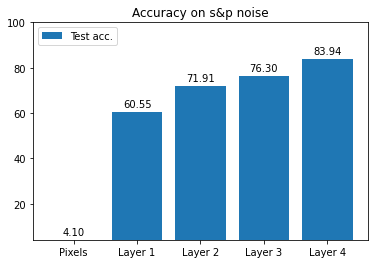

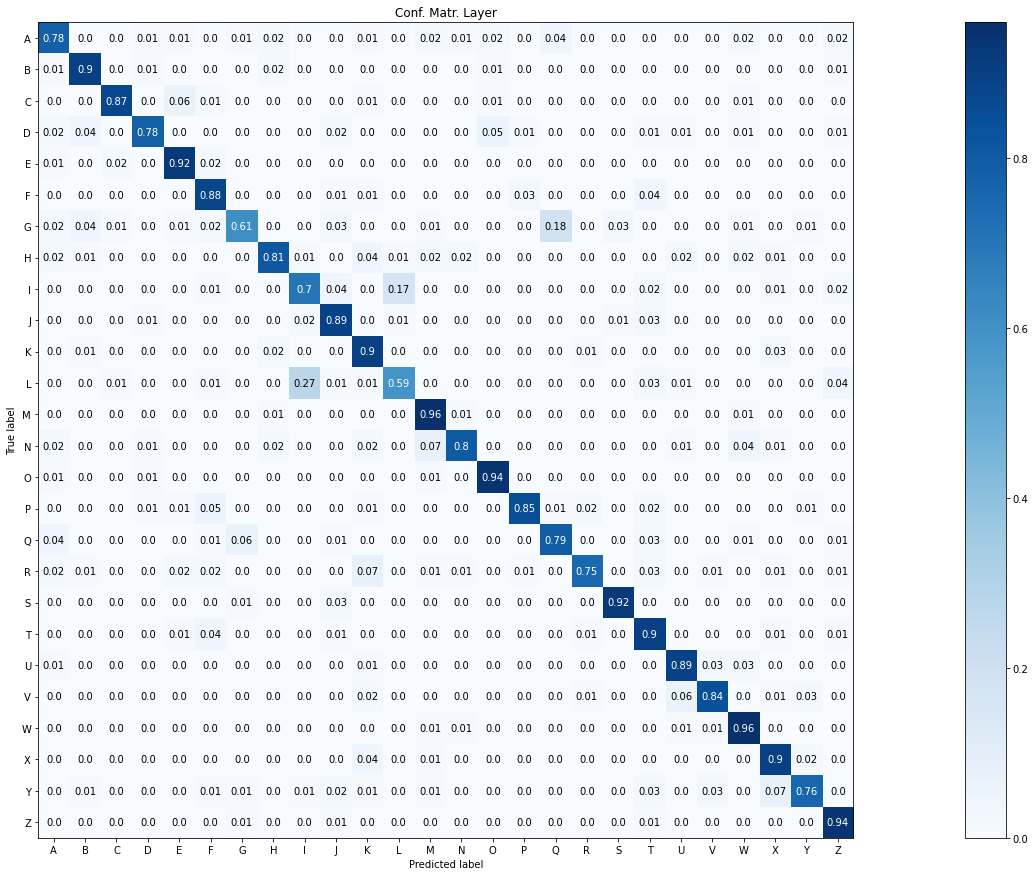

In [49]:
noise_modes = ['gaussian', 's&p']
for mode in noise_modes:
  if mode == 'gaussian':
    rnd_x_test = random_noise(x_test, mode=mode, mean=0, var=0.05)
  else:
    rnd_x_test = random_noise(x_test, mode=mode, amount = 0.15)
  results_noise = []
  accuracy_rnd, _ = predict(raw_model_weights, rnd_x_test, y_test)
  results_noise.append(accuracy_rnd.copy())
  prev_test = rnd_x_test.copy()
  i = 1
  n_layers = dbn_model.DN['nlayers']
  for layer_idx in range(nlayers):
      H_te_rnd = dbn_model.get_learned_map_features(prev_test, layer_idx)
      accuracy_rnd, pred_rnd = predict(layer_model_weights[layer_idx], H_te_rnd, y_test)
      results_noise.append(accuracy_rnd)
      prev_test = H_te_rnd
      i +=1

  #sample image
  fig, ax = plt.subplots(1, 2)
  fig.suptitle("Example of {0} noise".format(mode), fontsize=12)
  ax[0].imshow(rotate(x_test[1000]), cmap='gray')
  ax[1].imshow(rotate(rnd_x_test[1000]), cmap='gray')

  #bar plot accuracies
  fig, axes = plt.subplots(1, 1)
  results_noise = np.array(results_noise) * 100
  x = np.arange(len(results_noise)) 
  bar_te = axes.bar(x, np.array(results_noise), label='Test acc.')
  axes.set_xticks(x)
  labels = list(map(lambda value : 'Layer {0}'.format(value), x))
  labels[0] = 'Pixels'
  axes.set_xticklabels(labels)
  axes.legend(loc='upper left')
  axes.set_label("Percentage")
  axes.set_title("Accuracy on {0} noise".format(mode))
  minimum = results_noise.min()
  if minimum > 5:
    minimum -= 4
  axes.set_ylim(minimum, 100)
  autolabel(bar_te, axes)
  plt.show()

  #confusion matrix
  fig, axes = plt.subplots(1, 1, figsize=(40,15))
  plot_conf_matrix(y_test, pred_rnd, 'Conf. Matr. Layer', axes, namedataset)
  plt.show()

In [ ]:
plot_visihidlayers(DN=dbn_model.DN, idx_layers=[2, 1, 0], n_hidden=100, figsize=(20,20))

In [ ]:
loadmatname = 'DN_COLAB_{0}.mat'.format(dbn_model.to_string())
scipy.io.loadmat(savematname, {'DN': dbn_model.DN})

In [ ]:
import scipy as sy
from scipy.optimize import curve_fit

d = np.array([75, 80, 90, 95, 100, 105, 110, 115, 120, 125], dtype=float)
p1 = np.array([6, 13, 25, 29, 29, 29, 30, 29, 30, 30], dtype=float) / 30. # scale to 0..1

# psychometric function
def pf(x, alpha, beta):
    return 1. / (1 + np.exp( -(x-alpha)/beta ))

# fitting
par0 = np.array([100., 1.]) # use some good starting values, reasonable default is [0., 1.]
par, mcov = curve_fit(pf, d, p1, par0)
print(par)
plt.plot(d, p1, 'ro')
plt.plot(d, pf(d, par[0], par[1]))
plt.show()